<a href="https://colab.research.google.com/github/Farski96/DESAFIODIO/blob/main/FIAP_FASE_3_FINETUNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1Ô∏è‚É£ INSTALA√á√ÉO R√ÅPIDA
!pip install -q --upgrade pip
!pip install -q accelerate bitsandbytes einops sentencepiece
!pip install -q git+https://github.com/huggingface/peft.git
!pip install -q unsloth xformers trl
!pip install -q --upgrade transformers datasets tqdm
!pip install -U pyarrow
!pip install -U bitsandbytes transformers datasets pyarrow accelerate peft


   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.8/1.8 MB 74.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 21.0.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth 2025.10.1 requires transformers!=4.52.0,!=4.52.1,!=4.52.2,!=4.52.3,!=4.53.0,!

In [2]:
# 2Ô∏è‚É£ IMPORTS
import os
import torch
import time
import gc
from google.colab import drive
from pathlib import Path
from datasets import load_dataset
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

print("‚úÖ Pacotes importados com sucesso!\n")



‚úÖ Pacotes importados com sucesso!



In [3]:
# 3Ô∏è‚É£ MONTAR DRIVE
from google.colab import drive
drive.mount('/content/drive')

# 4Ô∏è‚É£ CONFIGURAR DIRET√ìRIOS
BASE_DIR = Path("/content/drive/MyDrive/tc_fiap_ft1")
BASE_DIR.mkdir(parents=True, exist_ok=True)

INPUT_FILE = BASE_DIR / "trn.json"
CHUNKS_DIR = BASE_DIR / "chunks"
OUTPUT_DIR = BASE_DIR / "output"
TOKENIZED_DIR = BASE_DIR / "tokenized_datasets"

for d in [CHUNKS_DIR, OUTPUT_DIR, TOKENIZED_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"üìÅ Diret√≥rios configurados:")
print(f"   Base: {BASE_DIR}")
print(f"   Output: {OUTPUT_DIR}\n")

# 5Ô∏è‚É£ VERIFICAR GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"üñ•Ô∏è  GPU: {gpu_name}")
    print(f"üíæ VRAM: {gpu_memory:.0f} GB\n")
else:
    print("‚ö†Ô∏è  Sem GPU detectada!\n")



Mounted at /content/drive
üìÅ Diret√≥rios configurados:
   Base: /content/drive/MyDrive/tc_fiap_ft1
   Output: /content/drive/MyDrive/tc_fiap_ft1/output

üñ•Ô∏è  GPU: NVIDIA A100-SXM4-80GB
üíæ VRAM: 85 GB



In [4]:
# 6Ô∏è‚É£ CARREGAR MODELO E TOKENIZER
print("üì¶ Carregando modelo LLaMA 3.2-1B...")
model_name = "unsloth/Llama-3.2-1B-bnb-4bit"

tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

model = prepare_model_for_kbit_training(model)
model.gradient_checkpointing_enable()

print("‚úÖ Modelo carregado!\n")

# 7Ô∏è‚É£ CONFIGURAR LORA (Otimizado para velocidade)
print("üîß Aplicando LoRA...")
lora_config = LoraConfig(
    r=16,  # Rank reduzido para velocidade
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Menos m√≥dulos = mais r√°pido
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
print(f"‚úÖ LoRA aplicado!")
model.print_trainable_parameters()
print()

üì¶ Carregando modelo LLaMA 3.2-1B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

‚úÖ Modelo carregado!

üîß Aplicando LoRA...
‚úÖ LoRA aplicado!
trainable params: 3,407,872 || all params: 1,239,222,272 || trainable%: 0.2750



In [ ]:

# 8Ô∏è‚É£ CARREGAR OU PROCESSAR DATASETS
train_path = TOKENIZED_DIR / "train"
eval_path = TOKENIZED_DIR / "eval"

if train_path.exists() and eval_path.exists():
    print("‚ôªÔ∏è  Carregando datasets tokenizados do cache...")
    tokenized_train = load_from_disk(str(train_path))
    tokenized_eval = load_from_disk(str(eval_path))
    print(f"‚úÖ Train: {len(tokenized_train):,} | Eval: {len(tokenized_eval):,}\n")

else:
    print("üîÑ Processando datasets pela primeira vez...\n")

    # Carregar JSONs
    json_files = sorted([str(f) for f in CHUNKS_DIR.glob("*.json")])
    if not json_files:
        print(f"‚ùå Nenhum arquivo JSON em {CHUNKS_DIR}")
        print(f"üí° Coloque seus arquivos chunk_*.json em: {CHUNKS_DIR}\n")
        raise FileNotFoundError("Arquivos JSON n√£o encontrados!")

    print(f"üìä Carregando {len(json_files)} arquivo(s)...")
    dataset = load_dataset("json", data_files=json_files, split="train")

    # Split train/eval
    split = dataset.train_test_split(test_size=0.05, seed=42)  # 5% eval (menos = mais r√°pido)
    train_dataset = split["train"]
    eval_dataset = split["test"]

    print(f"üìä Train: {len(train_dataset):,} | Eval: {len(eval_dataset):,}")

    # Tokeniza√ß√£o
    max_length = 1024  #
    def preprocess(examples):
        """Formata exemplos no padr√£o Alpaca"""

        # Pegar t√≠tulos (se n√£o existir, usa string vazia)
        titles = examples.get("title", [])
        if not titles:
            titles = [""] * len(examples.get("content", []))

        # Pegar conte√∫dos
        contents = examples.get("content", [])

        # Criar lista de textos no formato ALPACA
        texts = []
        for title, content in zip(titles, contents):
            # Formato Alpaca: Instruction ‚Üí Input ‚Üí Response
            alpaca_prompt = f"""

          ### Instruction:
          Descreva o produto a seguir de forma detalhada e persuasiva.

          ### Input:
          {title}

          ### Response:
          {content}"""
            texts.append(alpaca_prompt)

        # Tokenizar
        tokenized = tokenizer(
            texts,
            truncation=True,
            padding="max_length",
            max_length=max_length,
            return_tensors=None
        )
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized

    print("üîÑ Tokenizando (isso pode levar 10-15 min)...")
    tokenized_train = train_dataset.map(
        preprocess,
        batched=True,
        batch_size=2000,
        num_proc=4,
        remove_columns=train_dataset.column_names,
        desc="Tokenizando treino"
    )

    tokenized_eval = eval_dataset.map(
        preprocess,
        batched=True,
        batch_size=2000,
        num_proc=4,
        remove_columns=eval_dataset.column_names,
        desc="Tokenizando eval"
    )

    # Salvar para pr√≥ximas execu√ß√µes
    print("üíæ Salvando cache...")
    tokenized_train.save_to_disk(str(train_path))
    tokenized_eval.save_to_disk(str(eval_path))
    print(f"‚úÖ Cache salvo em: {TOKENIZED_DIR}\n")

# 9Ô∏è‚É£ DATA COLLATOR
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    return_tensors="pt"
)

# üîü TRAINING ARGUMENTS - M√ÅXIMA VELOCIDADE
print("‚öôÔ∏è  Configurando treinamento...\n")
training_args = TrainingArguments(
    output_dir="/tmp/training_output",  # /tmp = mais r√°pido que Drive

    # BATCH - Otimizado para A100 sem estourar RAM
    per_device_train_batch_size=32,  # M√°ximo seguro para A100
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,  # Sem acumula√ß√£o = mais r√°pido

    # LEARNING
    learning_rate=5e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,

    # PRECIS√ÉO
    bf16=True,
    bf16_full_eval=True,

    # LOGGING M√çNIMO
    logging_steps=100,
    logging_first_step=True,

    # SEM SALVAMENTO DURANTE TREINO
    save_strategy="no",
    save_steps=999999,

    # AVALIA√á√ÉO M√çNIMA
    eval_strategy="steps",
    eval_steps=500,  # Apenas 4 avalia√ß√µes

    # STEPS
    num_train_epochs=1,
    max_steps=4000,

    # OTIMIZA√á√ïES
    optim="adamw_torch_fused",
    gradient_checkpointing=True,

    # DATALOADER R√ÅPIDO
    dataloader_num_workers=2,  # 2 workers = balan√ßo velocidade/RAM
    dataloader_pin_memory=True,

    # SEM EXTRAS
    report_to="none",
    load_best_model_at_end=False,
    disable_tqdm=False,
)

# 1Ô∏è‚É£1Ô∏è‚É£ CRIAR TRAINER
trainer = Trainer(
    model=model,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    tokenizer=tokenizer,
    args=training_args,
    data_collator=data_collator
)

print("‚úÖ Trainer configurado!")
print(f"üéØ Total steps: {training_args.max_steps}")
print(f"‚è±Ô∏è  Tempo estimado: ~{training_args.max_steps/60:.0f} minutos\n")

# 1Ô∏è‚É£2Ô∏è‚É£ TREINAR
print("="*100)
print("üî• INICIANDO TREINAMENTO".center(100))
print("="*100)
print(f"\n‚öôÔ∏è  Configura√ß√£o:")
print(f"   ‚Ä¢ Batch Size: {training_args.per_device_train_batch_size}")
print(f"   ‚Ä¢ Max Length: 1024 tokens")
print(f"   ‚Ä¢ Learning Rate: {training_args.learning_rate}")
print(f"   ‚Ä¢ Steps: {training_args.max_steps}")
print(f"   ‚Ä¢ Eval: A cada 500 steps")
print(f"   ‚Ä¢ Checkpoints: Desabilitados")
print(f"   ‚Ä¢ Precis√£o: BFloat16")
print(f"‚è±Ô∏è  ETA: ~{training_args.max_steps/60:.0f} minutos")
print("="*100 + "\n")

start_time = time.time()

try:
    trainer.train()
    print("\n‚úÖ Treinamento conclu√≠do!\n")

except KeyboardInterrupt:
    print("\n‚ö†Ô∏è  Treinamento interrompido pelo usu√°rio!\n")

except Exception as e:
    print(f"\n‚ùå Erro: {e}\n")
    raise

finally:
    training_time = (time.time() - start_time) / 60
    print(f"‚è±Ô∏è  Tempo de treinamento: {training_time:.1f} minutos")

    # Limpar mem√≥ria
    gc.collect()
    torch.cuda.empty_cache()

# 1Ô∏è‚É£3Ô∏è‚É£ SALVAR MODELO FINAL
print("\n" + "="*100)
print("üíæ SALVANDO MODELO FINAL".center(100))
print("="*100 + "\n")

final_model_path = OUTPUT_DIR / "final_model"

try:
    model.save_pretrained(str(final_model_path))
    tokenizer.save_pretrained(str(final_model_path))

    print(f"‚úÖ Modelo salvo em: {final_model_path}\n")

    # Mostrar arquivos
    print("üìÅ Arquivos gerados:")
    for file in sorted(final_model_path.iterdir()):
        size = file.stat().st_size / (1024*1024)
        print(f"   ‚Ä¢ {file.name}: {size:.1f} MB")

except Exception as e:
    print(f"‚ùå Erro ao salvar: {e}\n")
    raise



‚ôªÔ∏è  Carregando datasets tokenizados do cache...


Loading dataset from disk:   0%|          | 0/33 [00:00<?, ?it/s]

/tmp/ipython-input-3342026627.py:153: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


‚úÖ Train: 1,229,886 | Eval: 136,655

‚öôÔ∏è  Configurando treinamento...

‚úÖ Trainer configurado!
üéØ Total steps: 4000
‚è±Ô∏è  Tempo estimado: ~67 minutos

                                      üî• INICIANDO TREINAMENTO                                       

‚öôÔ∏è  Configura√ß√£o:
   ‚Ä¢ Batch Size: 32
   ‚Ä¢ Max Length: 2048 tokens
   ‚Ä¢ Learning Rate: 0.0005
   ‚Ä¢ Steps: 4000
   ‚Ä¢ Eval: A cada 500 steps
   ‚Ä¢ Checkpoints: Desabilitados
   ‚Ä¢ Precis√£o: BFloat16
‚è±Ô∏è  ETA: ~67 minutos




‚úÖ Treinamento conclu√≠do!

‚è±Ô∏è  Tempo de treinamento: 610.9 minutos

                                      üíæ SALVANDO MODELO FINAL                                       

‚úÖ Modelo salvo em: /content/drive/MyDrive/tc_fiap_ft1/output/final_model

üìÅ Arquivos gerados:
   ‚Ä¢ README.md: 0.0 MB
   ‚Ä¢ adapter_config.json: 0.0 MB
   ‚Ä¢ adapter_model.safetensors: 13.0 MB
   ‚Ä¢ special_tokens_map.json: 0.0 MB
   ‚Ä¢ tokenizer.json: 16.4 MB
   ‚Ä¢ tokenizer_config.json: 0.0 MB


In [ ]:
# 1Ô∏è‚É£4Ô∏è‚É£ ESTAT√çSTICAS FINAIS
print("\n" + "="*100)
print("üìä RESUMO DO TREINAMENTO".center(100))
print("="*100 + "\n")

if hasattr(trainer.state, 'log_history') and trainer.state.log_history:
    logs = trainer.state.log_history
    train_losses = [log['loss'] for log in logs if 'loss' in log]
    eval_losses = [log['eval_loss'] for log in logs if 'eval_loss' in log]

    if train_losses:
        print("‚ïî" + "‚ïê"*98 + "‚ïó")
        print("‚ïë" + " üìà M√âTRICAS FINAIS ".center(98) + "‚ïë")
        print("‚ï†" + "‚ïê"*98 + "‚ï£")
        print(f"‚ïë  üéØ Steps: {trainer.state.global_step:,}/{training_args.max_steps:,}".ljust(99) + "‚ïë")
        print(f"‚ïë  ‚è±Ô∏è  Tempo: {training_time:.1f} minutos".ljust(99) + "‚ïë")
        print(f"‚ïë  ‚ö° Velocidade: {trainer.state.global_step/training_time:.1f} steps/min".ljust(99) + "‚ïë")
        print("‚ïë" + " "*98 + "‚ïë")
        print(f"‚ïë  üìâ Loss Inicial: {train_losses[0]:.4f}".ljust(99) + "‚ïë")
        print(f"‚ïë  üìâ Loss Final: {train_losses[-1]:.4f}".ljust(99) + "‚ïë")

        if eval_losses:
            print(f"‚ïë  üìä Melhor Eval Loss: {min(eval_losses):.4f}".ljust(99) + "‚ïë")

        improvement = ((train_losses[0] - train_losses[-1]) / train_losses[0]) * 100
        print(f"‚ïë  üìà Melhoria: {improvement:.1f}%".ljust(99) + "‚ïë")
        print("‚ïö" + "‚ïê"*98 + "‚ïù")

print("\nüéâ TREINAMENTO CONCLU√çDO COM SUCESSO!")
print(f"üíæ Modelo pronto em: {final_model_path}")
print(f"üìä Datasets tokenizados em: {TOKENIZED_DIR}")
print("\n‚úÖ Pr√≥xima execu√ß√£o ser√° mais r√°pida (usa cache)!")
print("="*100 + "\n")


                                      üìä RESUMO DO TREINAMENTO                                       

‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë                                        üìà M√âTRICAS FINAIS                                         ‚ïë
‚ï†‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï£
‚ïë  üéØ Steps: 4,000/4,000                                                                            ‚ïë
‚ïë  ‚è±Ô∏è  Tempo: 610.9 minutos                                          

TESTES

In [5]:
# ==================== SUITE DE TESTES COMPLETA DO MODELO ====================
# Execute ap√≥s o treinamento para avaliar performance

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_from_disk, load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import json
from sklearn.metrics import confusion_matrix
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# ==================== 1Ô∏è‚É£ CONFIGURA√á√ÉO ====================
print("="*80)
print("üß™ SUITE DE TESTES - LLAMA 3.2 FINE-TUNED".center(80))
print("="*80 + "\n")

# ==================== BASE CONFIG ====================

# MONTAR DRIVE
from google.colab import drive

# Check if Google Drive is already mounted
try:
    drive.mount('/content/drive', force_remount=True)
    print("‚úÖ Google Drive montado com sucesso!")
except ValueError as e:
    if "Mountpoint must not already contain files" in str(e):
        print("‚ö†Ô∏è Google Drive j√° est√° montado.")
    else:
        print(f"‚ùå Erro ao montar Google Drive: {e}")
except Exception as e:
    print(f"‚ùå Ocorreu um erro inesperado ao montar o Google Drive: {e}")

BASE_DIR = Path("/content/drive/MyDrive/tc_fiap_ft1")

# Caminhos padronizados
MODEL_PATH = BASE_DIR / "output" / "final_model"

TOKENIZED_DATASET_DIR = BASE_DIR / "tokenized_datasets"
TEST_RESULTS_DIR = BASE_DIR / "test_results"
# Caminho dos datasets tokenizados
TOKENIZED_DATASET_DIR = BASE_DIR / "tokenized_datasets"
TEST_RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Verificar se modelo existe
if not MODEL_PATH.exists():
    raise FileNotFoundError(f"‚ùå Modelo n√£o encontrado em: {MODEL_PATH}")

# ==================== 2Ô∏è‚É£ CARREGAR MODELO ====================
logger.info("üì• Carregando modelo fine-tuned...")

tokenizer = AutoTokenizer.from_pretrained(str(MODEL_PATH))
model = AutoModelForCausalLM.from_pretrained(
    str(MODEL_PATH),
    device_map="auto",
    torch_dtype=torch.float16
)
model.eval()

logger.info("‚úÖ Modelo carregado com sucesso!")



                    üß™ SUITE DE TESTES - LLAMA 3.2 FINE-TUNED                    

Mounted at /content/drive
‚úÖ Google Drive montado com sucesso!


In [18]:
# ==================== 3Ô∏è‚É£ TESTE 1: GERA√á√ÉO DE TEXTO ====================
print("\n" + "‚îÄ"*80)
print("üìù TESTE 1: QUALIDADE DE GERA√á√ÉO DE TEXTO")
print("‚îÄ"*80)

def test_text_generation(model, tokenizer, prompts, max_length=512):
    """Testa gera√ß√£o de texto com diferentes prompts"""
    results = []

    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        num_return_sequences=1
    )

    for prompt in tqdm(prompts, desc="Gerando textos"):
        try:
            output = generator(prompt, max_new_tokens=200)
            generated_text = output[0]['generated_text']

            results.append({
                'prompt': prompt,
                'generated': generated_text,
                'length': len(generated_text.split()),
                'success': True
            })
        except Exception as e:
            results.append({
                'prompt': prompt,
                'generated': f"ERRO: {str(e)}",
                'length': 0,
                'success': False
            })

    return pd.DataFrame(results)

# Prompts de teste diversos
test_prompts = [
    #"### T√≠tulo: describe office chair\n### Conte√∫do:",
    #"### T√≠tulo: Ol√°, tudo bem\n### Conte√∫do:",
    "### T√≠tulo: give me cookie recipes\n### Conte√∫do:",
    "### T√≠tulo: tell me a good book to read\n### Conte√∫do:",
    "### T√≠tulo: how to buy a car in home\n### Conte√∫do:",
]

generation_results = test_text_generation(model, tokenizer, test_prompts)
generation_results.to_csv(TEST_RESULTS_DIR / "test_generation.csv", index=False)

print(f"\n‚úÖ Teste de gera√ß√£o conclu√≠do!")
print(f"   Taxa de sucesso: {generation_results['success'].mean()*100:.1f}%")
print(f"   Comprimento m√©dio: {generation_results['length'].mean():.1f} palavras")

# Exibir exemplos
print("\nüìÑ Exemplo de gera√ß√£o:")
print("‚îÄ"*80)
sample = generation_results.iloc[0]
print(f"Prompt: {sample['prompt'][:50]}...")
print(f"Gerado: {sample['generated'][:300]}...")
print("‚îÄ"*80)



Device set to use cuda:0



‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìù TESTE 1: QUALIDADE DE GERA√á√ÉO DE TEXTO
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


Gerando textos:   0%|          | 0/3 [00:00<?, ?it/s]


‚úÖ Teste de gera√ß√£o conclu√≠do!
   Taxa de sucesso: 100.0%
   Comprimento m√©dio: 173.3 palavras

üìÑ Exemplo de gera√ß√£o:
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
Prompt: ### T√≠tulo: give me cookie recipes
### Conte√∫do:...
Gerado: ### T√≠tulo: give me cookie recipes
### Conte√∫do: I had a lot of fun writing this book. I hope you have as much fun reading it. --Judy Rodgers, author of The Cake BibleI love cookie recipes. I have a lot of them. And I love them even more when they come from Judy Rodgers. --Cara Alwell, author of The...
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


In [19]:
# ==================== 3Ô∏è‚É£ TESTE GERA√á√ÉO DE TEXTO ALPACA ====================
print("\n" + "‚îÄ"*80)
print("üìù TESTE 1: QUALIDADE DE GERA√á√ÉO DE TEXTO")
print("‚îÄ"*80)

def test_text_generation(model, tokenizer, prompts, max_length=512):
    """Testa gera√ß√£o de texto com diferentes prompts"""
    results = []

    generator = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        max_length=max_length,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        num_return_sequences=1
    )

    for prompt in tqdm(prompts, desc="Gerando textos"):
        try:
            output = generator(prompt, max_new_tokens=200)
            generated_text = output[0]['generated_text']

            results.append({
                'prompt': prompt[:100] + "...",  # Mostrar s√≥ in√≠cio
                'generated': generated_text,
                'length': len(generated_text.split()),
                'success': True
            })
        except Exception as e:
            results.append({
                'prompt': prompt[:100] + "...",
                'generated': f"ERRO: {str(e)}",
                'length': 0,
                'success': False
            })

    return pd.DataFrame(results)

test_prompts = [
    # 1Ô∏è‚É£ Office product
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Premium Ergonomic Office Chair

### Response:
""",

    # 2Ô∏è‚É£ Electronics product
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Wireless RGB Gaming Mouse 16000 DPI

### Response:
""",

    # 3Ô∏è‚É£ Home appliance
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Professional Blender 1200W 12 Speeds

### Response:
""",

    # 4Ô∏è‚É£ Clothing product
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
Running Shoes with Cushioning

### Response:
""",

    # 5Ô∏è‚É£ General consumer electronics
    """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Describe the following product in a detailed and persuasive way.

### Input:
55-Inch 4K HDR Smart TV

### Response:
"""
]

print(f"\nüéØ Testando com {len(test_prompts)} prompts no formato Alpaca...")
generation_results = test_text_generation(model, tokenizer, test_prompts)
generation_results.to_csv(TEST_RESULTS_DIR / "test_generation.csv", index=False)

print(f"\n‚úÖ Teste de gera√ß√£o conclu√≠do!")
print(f"   Taxa de sucesso: {generation_results['success'].mean()*100:.1f}%")
print(f"   Comprimento m√©dio: {generation_results['length'].mean():.1f} palavras")

# Exibir exemplos de cada categoria
print("\nüìÑ Exemplos de Gera√ß√£o:")
print("="*80)

for idx, row in generation_results.iterrows():
    if row['success']:
        # Extrair apenas a resposta gerada (ap√≥s "### Response:")
        generated = row['generated']
        if "### Response:" in generated:
            response = generated.split("### Response:")[-1].strip()
        else:
            response = generated

        print(f"\nüîπ TESTE {idx+1}:")
        print(f"Prompt: {row['prompt']}")
        print(f"\nüí¨ Resposta Gerada ({row['length']} palavras):")
        print(f"{response[:300]}{'...' if len(response) > 300 else ''}")
        print("‚îÄ"*80)
    else:
        print(f"\n‚ùå TESTE {idx+1}: FALHOU")
        print(f"Erro: {row['generated']}")
        print("‚îÄ"*80)

Device set to use cuda:0



‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìù TESTE 1: QUALIDADE DE GERA√á√ÉO DE TEXTO
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

üéØ Testando com 5 prompts no formato Alpaca...


Gerando textos:   0%|          | 0/5 [00:00<?, ?it/s]


‚úÖ Teste de gera√ß√£o conclu√≠do!
   Taxa de sucesso: 100.0%
   Comprimento m√©dio: 206.2 palavras

üìÑ Exemplos de Gera√ß√£o:

üîπ TESTE 1:
Prompt: Below is an instruction that describes a task, paired with an input that provides further context. W...

üí¨ Resposta Gerada (211 palavras):
A premium ergonomic office chair is a comfortable and supportive chair that is designed to fit the body, providing support for the back, neck, and shoulders. It is constructed with durable materials and features adjustable features to ensure a comfortable fit. A premium ergonomic office chair is a v...
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

üîπ TESTE 2:
Prompt: Below is an instruction that describes a task, paired with an input that provides further context. W...

üí¨ Resposta Gerada (210 palavr

In [20]:

# ==================== 4Ô∏è‚É£ TESTE 2: PERPLEXIDADE ====================
print("\n" + "‚îÄ"*80)
print("üìä TESTE 2: PERPLEXIDADE NO DATASET DE VALIDA√á√ÉO")
print("‚îÄ"*80)

def calculate_perplexity(model, tokenizer, dataset, max_samples=100):
    """Calcula perplexidade m√©dia"""
    device = next(model.parameters()).device
    total_loss = 0
    total_tokens = 0

    samples = min(len(dataset), max_samples)

    for i in tqdm(range(samples), desc="Calculando perplexidade"):
        try:
            inputs = tokenizer(
                dataset[i]['input_ids'],
                return_tensors="pt",
                truncation=True,
                max_length=512
            ).to(device)

            with torch.no_grad():
                outputs = model(**inputs, labels=inputs['input_ids'])
                loss = outputs.loss

            total_loss += loss.item() * inputs['input_ids'].size(1)
            total_tokens += inputs['input_ids'].size(1)
        except:
            continue

    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = np.exp(avg_loss)

    return perplexity, avg_loss

# Carregar dataset de valida√ß√£o
try:
    eval_dataset = load_from_disk(str(BASE_DIR / "tokenized_datasets" / "eval"))
    perplexity, avg_loss = calculate_perplexity(model, tokenizer, eval_dataset)

    print(f"\n‚úÖ Perplexidade calculada!")
    print(f"   Perplexidade: {perplexity:.2f}")
    print(f"   Loss m√©dio: {avg_loss:.4f}")

    # Salvar resultado
    perplexity_results = {
        'perplexity': float(perplexity),
        'avg_loss': float(avg_loss),
        'samples_evaluated': min(len(eval_dataset), 100)
    }

    with open(TEST_RESULTS_DIR / "test_perplexity.json", 'w') as f:
        json.dump(perplexity_results, f, indent=2)

except Exception as e:
    logger.warning(f"‚ö†Ô∏è N√£o foi poss√≠vel calcular perplexidade: {e}")
    perplexity_results = None




‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìä TESTE 2: PERPLEXIDADE NO DATASET DE VALIDA√á√ÉO
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


Calculando perplexidade:   0%|          | 0/100 [00:00<?, ?it/s]


‚úÖ Perplexidade calculada!
   Perplexidade: inf
   Loss m√©dio: inf


In [15]:
def calculate_perplexity_batch(model, dataset, tokenizer, max_samples=100, batch_size=8):
    """Calcula perplexidade m√©dia usando batches em dataset tokenizado"""
    device = next(model.parameters()).device
    total_loss = 0
    total_tokens = 0

    samples = min(len(dataset), max_samples)

    for start_idx in tqdm(range(0, samples, batch_size), desc="Calculando perplexidade (batches)"):
        end_idx = min(start_idx + batch_size, samples)
        batch = dataset[start_idx:end_idx]

        try:
            # Preparar input_ids e attention_mask
            input_ids_list = [torch.tensor(sample['input_ids']) for sample in batch]
            input_ids_padded = torch.nn.utils.rnn.pad_sequence(input_ids_list, batch_first=True, padding_value=tokenizer.pad_token_id)

            input_ids_padded = input_ids_padded.to(device)

            with torch.no_grad():
                outputs = model(input_ids_padded, labels=input_ids_padded)
                loss = outputs.loss

            # Seq_len: contar tokens v√°lidos para cada sample
            seq_lens = (input_ids_padded != tokenizer.pad_token_id).sum(dim=1)
            total_loss += (loss.item() * seq_lens.sum().item())  # pondera pelo total de tokens
            total_tokens += seq_lens.sum().item()

        except Exception as e:
            logger.warning(f"‚ö†Ô∏è Batch {start_idx}-{end_idx} falhou: {e}")
            continue

    avg_loss = total_loss / total_tokens if total_tokens > 0 else float('inf')
    perplexity = np.exp(avg_loss) if avg_loss < 100 else float('inf')

    return perplexity, avg_loss

    eval_dataset = load_from_disk(str(BASE_DIR / "tokenized_datasets" / "eval"))
perplexity, avg_loss = calculate_perplexity_batch(model, eval_dataset, tokenizer, max_samples=100, batch_size=8)

print(f"\n‚úÖ Perplexidade calculada!")
print(f"   Perplexidade: {perplexity:.2f}")
print(f"   Loss m√©dio: {avg_loss:.4f}")



Calculando perplexidade (batches):   0%|          | 0/13 [00:00<?, ?it/s]


‚úÖ Perplexidade calculada!
   Perplexidade: inf
   Loss m√©dio: inf


In [ ]:
# ==================== 5Ô∏è‚É£ TESTE 3: VELOCIDADE DE INFER√äNCIA ====================
print("\n" + "‚îÄ"*80)
print("‚ö° TESTE 3: VELOCIDADE DE INFER√äNCIA")
print("‚îÄ"*80)

def benchmark_inference_speed(model, tokenizer, num_iterations=20):
    """Mede velocidade de infer√™ncia"""
    device = next(model.parameters()).device

    test_prompt = "### T√≠tulo: Teste de Performance\n### Conte√∫do:"
    inputs = tokenizer(test_prompt, return_tensors="pt").to(device)

    # Warmup
    for _ in range(5):
        with torch.no_grad():
            _ = model.generate(**inputs, max_new_tokens=50)

    # Benchmark
    times = []
    tokens_generated = []

    for _ in tqdm(range(num_iterations), desc="Benchmarking"):
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        start = time.time()

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=100)

        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end = time.time()

        times.append(end - start)
        tokens_generated.append(outputs.shape[1] - inputs['input_ids'].shape[1])

    avg_time = np.mean(times)
    avg_tokens = np.mean(tokens_generated)
    tokens_per_sec = avg_tokens / avg_time

    return {
        'avg_time_sec': avg_time,
        'std_time_sec': np.std(times),
        'avg_tokens_generated': avg_tokens,
        'tokens_per_second': tokens_per_sec
    }

speed_results = benchmark_inference_speed(model, tokenizer)

print(f"\n‚úÖ Benchmark de velocidade conclu√≠do!")
print(f"   Tempo m√©dio: {speed_results['avg_time_sec']:.3f}s (¬±{speed_results['std_time_sec']:.3f}s)")
print(f"   Tokens/segundo: {speed_results['tokens_per_second']:.1f}")

with open(TEST_RESULTS_DIR / "test_speed.json", 'w') as f:
    json.dump(speed_results, f, indent=2)



‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö° TESTE 3: VELOCIDADE DE INFER√äNCIA
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


Benchmarking:   0%|          | 0/20 [00:00<?, ?it/s]


‚úÖ Benchmark de velocidade conclu√≠do!
   Tempo m√©dio: 5.765s (¬±0.051s)
   Tokens/segundo: 17.3


In [ ]:

# ==================== 6Ô∏è‚É£ TESTE 4: COMPARA√á√ÉO COM MODELO BASE ====================
print("\n" + "‚îÄ"*80)
print("üÜö TESTE 4: COMPARA√á√ÉO COM MODELO BASE")
print("‚îÄ"*80)

def compare_with_base_model(fine_tuned_model, base_model_name, test_prompts, tokenizer):
    """Compara modelo fine-tuned com modelo base"""

    # Carregar modelo base
    logger.info("Carregando modelo base para compara√ß√£o...")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        device_map="auto",
        torch_dtype=torch.float16,
        load_in_4bit=True
    )
    base_model.eval()

    results = []

    for prompt in tqdm(test_prompts, desc="Comparando modelos"):
        inputs = tokenizer(prompt, return_tensors="pt").to(fine_tuned_model.device)

        # Fine-tuned
        with torch.no_grad():
            ft_outputs = fine_tuned_model.generate(
                **inputs,
                max_new_tokens=100,
                do_sample=True,
                temperature=0.7
            )
        ft_text = tokenizer.decode(ft_outputs[0], skip_special_tokens=True)

        # Base
        inputs_base = inputs.to(base_model.device)
        with torch.no_grad():
            base_outputs = base_model.generate(
                **inputs_base,
                max_new_tokens=100,
                do_sample=True,
                temperature=0.7
            )
        base_text = tokenizer.decode(base_outputs[0], skip_special_tokens=True)

        results.append({
            'prompt': prompt,
            'fine_tuned': ft_text,
            'base_model': base_text,
            'ft_length': len(ft_text.split()),
            'base_length': len(base_text.split())
        })

    return pd.DataFrame(results)

try:
    comparison_prompts = test_prompts[:3]  # Apenas 3 para economizar tempo
    comparison_df = compare_with_base_model(
        model,
        "unsloth/Llama-3.2-1B",
        comparison_prompts,
        tokenizer
    )

    comparison_df.to_csv(TEST_RESULTS_DIR / "test_comparison.csv", index=False)
    print(f"\n‚úÖ Compara√ß√£o conclu√≠da!")

except Exception as e:
    logger.warning(f"‚ö†Ô∏è N√£o foi poss√≠vel comparar com modelo base: {e}")
    comparison_df = None




‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üÜö TESTE 4: COMPARA√á√ÉO COM MODELO BASE
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


config.json:   0%|          | 0.00/889 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

Comparando modelos:   0%|          | 0/3 [00:00<?, ?it/s]


‚úÖ Compara√ß√£o conclu√≠da!


In [ ]:
# ==================== 7Ô∏è‚É£ TESTE 5: AN√ÅLISE DE TOKENS ====================
print("\n" + "‚îÄ"*80)
print("üî§ TESTE 5: AN√ÅLISE DE DISTRIBUI√á√ÉO DE TOKENS")
print("‚îÄ"*80)

def analyze_token_distribution(model, tokenizer, dataset, num_samples=100):
    """Analisa distribui√ß√£o de tokens gerados"""
    all_tokens = []

    for i in tqdm(range(min(num_samples, len(dataset))), desc="Analisando tokens"):
        try:
            sample_text = tokenizer.decode(dataset[i]['input_ids'][:100])
            inputs = tokenizer(sample_text, return_tensors="pt").to(model.device)

            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=50, output_scores=True, return_dict_in_generate=True)

            tokens = outputs.sequences[0].cpu().tolist()
            all_tokens.extend(tokens)
        except:
            continue

    # An√°lise estat√≠stica
    unique_tokens = len(set(all_tokens))
    total_tokens = len(all_tokens)
    token_diversity = unique_tokens / total_tokens if total_tokens > 0 else 0

    return {
        'total_tokens': total_tokens,
        'unique_tokens': unique_tokens,
        'diversity_ratio': token_diversity,
        'vocab_size': tokenizer.vocab_size
    }

try:
    token_stats = analyze_token_distribution(model, tokenizer, eval_dataset)

    print(f"\n‚úÖ An√°lise de tokens conclu√≠da!")
    print(f"   Tokens √∫nicos: {token_stats['unique_tokens']:,}")
    print(f"   Diversidade: {token_stats['diversity_ratio']:.2%}")

    with open(TEST_RESULTS_DIR / "test_token_analysis.json", 'w') as f:
        json.dump(token_stats, f, indent=2)

except Exception as e:
    logger.warning(f"‚ö†Ô∏è Erro na an√°lise de tokens: {e}")




‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üî§ TESTE 5: AN√ÅLISE DE DISTRIBUI√á√ÉO DE TOKENS
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


Analisando tokens:   0%|          | 0/100 [00:00<?, ?it/s]


‚úÖ An√°lise de tokens conclu√≠da!
   Tokens √∫nicos: 3,608
   Diversidade: 23.90%



‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
üìä GERANDO RELAT√ìRIO VISUAL COMPLETO
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


/tmp/ipython-input-750379048.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 127386 (\N{SQUARED VS}) missing from font(s) DejaVu Sans.
  plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-750379048.py:105: UserWarning: Glyph 

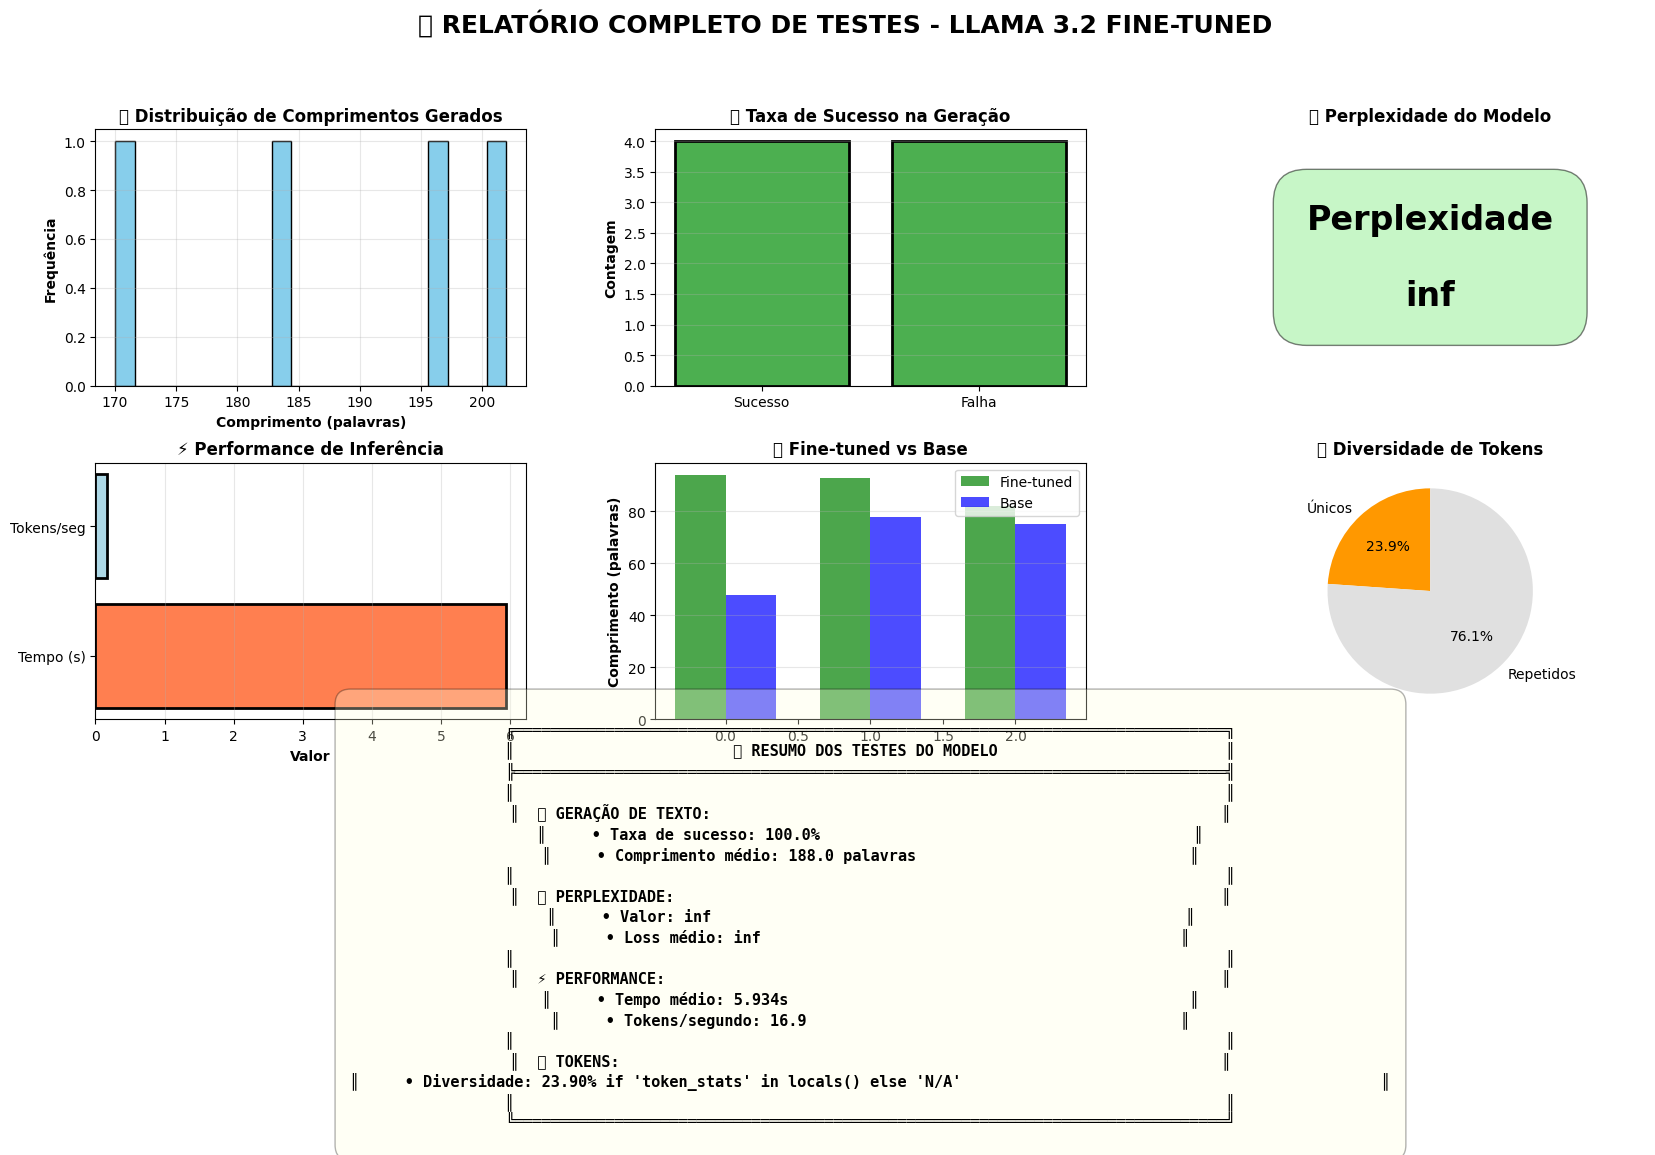


‚úÖ Relat√≥rio visual salvo em: /content/drive/MyDrive/tc_fiap_ft1/test_results/test_report_complete.png
‚úÖ Relat√≥rio JSON salvo em: /content/drive/MyDrive/tc_fiap_ft1/test_results/consolidated_test_report.json


In [ ]:
# ==================== 8Ô∏è‚É£ GERAR RELAT√ìRIO VISUAL ====================
print("\n" + "‚îÄ"*80)
print("üìä GERANDO RELAT√ìRIO VISUAL COMPLETO")
print("‚îÄ"*80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Compara√ß√£o de comprimentos
if 'generation_results' in locals():
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(generation_results['length'], bins=20, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Comprimento (palavras)', fontweight='bold')
    ax1.set_ylabel('Frequ√™ncia', fontweight='bold')
    ax1.set_title('üìè Distribui√ß√£o de Comprimentos Gerados', fontweight='bold')
    ax1.grid(True, alpha=0.3)

# 2. Taxa de sucesso
if 'generation_results' in locals():
    ax2 = fig.add_subplot(gs[0, 1])
    success_rate = generation_results['success'].value_counts()
    colors = ['#4CAF50' if idx else '#F44336' for idx in success_rate.index]
    ax2.bar(['Sucesso', 'Falha'], success_rate.values, color=colors, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Contagem', fontweight='bold')
    ax2.set_title('‚úÖ Taxa de Sucesso na Gera√ß√£o', fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

# 3. Perplexidade
if perplexity_results:
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.text(0.5, 0.5, f"Perplexidade\n\n{perplexity_results['perplexity']:.2f}",
             ha='center', va='center', fontsize=24, fontweight='bold',
             bbox=dict(boxstyle='round,pad=1', facecolor='lightgreen', alpha=0.5))
    ax3.axis('off')
    ax3.set_title('üìä Perplexidade do Modelo', fontweight='bold')

# 4. Velocidade de infer√™ncia
if 'speed_results' in locals():
    ax4 = fig.add_subplot(gs[1, 0])
    metrics = ['Tempo (s)', 'Tokens/seg']
    values = [speed_results['avg_time_sec'], speed_results['tokens_per_second']/100]
    ax4.barh(metrics, values, color=['coral', 'lightblue'], edgecolor='black', linewidth=2)
    ax4.set_xlabel('Valor', fontweight='bold')
    ax4.set_title('‚ö° Performance de Infer√™ncia', fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='x')

# 5. Compara√ß√£o comprimentos (se dispon√≠vel)
if comparison_df is not None:
    ax5 = fig.add_subplot(gs[1, 1])
    x = np.arange(len(comparison_df))
    width = 0.35
    ax5.bar(x - width/2, comparison_df['ft_length'], width, label='Fine-tuned', color='green', alpha=0.7)
    ax5.bar(x + width/2, comparison_df['base_length'], width, label='Base', color='blue', alpha=0.7)
    ax5.set_ylabel('Comprimento (palavras)', fontweight='bold')
    ax5.set_title('üÜö Fine-tuned vs Base', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3, axis='y')

# 6. Diversidade de tokens
if 'token_stats' in locals():
    ax6 = fig.add_subplot(gs[1, 2])
    labels = ['√önicos', 'Repetidos']
    sizes = [token_stats['unique_tokens'], token_stats['total_tokens'] - token_stats['unique_tokens']]
    colors = ['#FF9800', '#E0E0E0']
    ax6.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
    ax6.set_title('üî§ Diversidade de Tokens', fontweight='bold')

# 7. Resumo textual
ax7 = fig.add_subplot(gs[2, :])
ax7.axis('off')

summary = f"""
‚ïî‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïó
‚ïë                        üìã RESUMO DOS TESTES DO MODELO                         ‚ïë
‚ï†‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï£
‚ïë                                                                              ‚ïë
‚ïë  ‚úÖ GERA√á√ÉO DE TEXTO:                                                        ‚ïë
‚ïë     ‚Ä¢ Taxa de sucesso: {generation_results['success'].mean()*100:.1f}%                                         ‚ïë
‚ïë     ‚Ä¢ Comprimento m√©dio: {generation_results['length'].mean():.1f} palavras                              ‚ïë
‚ïë                                                                              ‚ïë
‚ïë  üìä PERPLEXIDADE:                                                            ‚ïë
‚ïë     ‚Ä¢ Valor: {perplexity_results['perplexity'] if perplexity_results else 'N/A'}                                                    ‚ïë
‚ïë     ‚Ä¢ Loss m√©dio: {perplexity_results['avg_loss'] if perplexity_results else 'N/A'}                                              ‚ïë
‚ïë                                                                              ‚ïë
‚ïë  ‚ö° PERFORMANCE:                                                             ‚ïë
‚ïë     ‚Ä¢ Tempo m√©dio: {speed_results['avg_time_sec']:.3f}s                                            ‚ïë
‚ïë     ‚Ä¢ Tokens/segundo: {speed_results['tokens_per_second']:.1f}                                         ‚ïë
‚ïë                                                                              ‚ïë
‚ïë  üî§ TOKENS:                                                                  ‚ïë
‚ïë     ‚Ä¢ Diversidade: {token_stats['diversity_ratio']:.2%} if 'token_stats' in locals() else 'N/A'                                              ‚ïë
‚ïë                                                                              ‚ïë
‚ïö‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïù
"""

ax7.text(0.5, 0.5, summary, transform=ax7.transAxes,
         fontsize=11, verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', weight='bold',
         bbox=dict(boxstyle='round,pad=1', facecolor='lightyellow', alpha=0.3))

plt.suptitle('üß™ RELAT√ìRIO COMPLETO DE TESTES - LLAMA 3.2 FINE-TUNED',
             fontsize=18, fontweight='bold', y=0.98)

plt.tight_layout()
report_path = TEST_RESULTS_DIR / "test_report_complete.png"
plt.savefig(report_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n‚úÖ Relat√≥rio visual salvo em: {report_path}")

# ==================== 9Ô∏è‚É£ SALVAR RELAT√ìRIO JSON CONSOLIDADO ====================
consolidated_report = {
    'model_path': str(MODEL_PATH),
    'test_date': pd.Timestamp.now().isoformat(),
    'generation': {
        'success_rate': float(generation_results['success'].mean()),
        'avg_length': float(generation_results['length'].mean())
    },
    'perplexity': perplexity_results if perplexity_results else {},
    'speed': speed_results,
    'tokens': token_stats if 'token_stats' in locals() else {}
}

report_json_path = TEST_RESULTS_DIR / "consolidated_test_report.json"
with open(report_json_path, 'w') as f:
    json.dump(consolidated_report, f, indent=2)

print(f"‚úÖ Relat√≥rio JSON salvo em: {report_json_path}")


In [ ]:

# ==================== üîü CONCLUS√ÉO ====================
print("\n" + "="*80)
print("üéâ TODOS OS TESTES CONCLU√çDOS COM SUCESSO!".center(80))
print("="*80)
print(f"\nüìÅ Todos os resultados salvos em: {TEST_RESULTS_DIR}")
print(f"\nüìÑ Arquivos gerados:")
print(f"   ‚Ä¢ test_generation.csv - Resultados de gera√ß√£o")
print(f"   ‚Ä¢ test_perplexity.json - M√©tricas de perplexidade")
print(f"   ‚Ä¢ test_speed.json - Benchmark de velocidade")
print(f"   ‚Ä¢ test_comparison.csv - Compara√ß√£o com modelo base")
print(f"   ‚Ä¢ test_token_analysis.json - An√°lise de tokens")
print(f"   ‚Ä¢ test_report_complete.png - Relat√≥rio visual")
print(f"   ‚Ä¢ consolidated_test_report.json - Relat√≥rio consolidado")
print("\n" + "="*80 + "\n")


                   üéâ TODOS OS TESTES CONCLU√çDOS COM SUCESSO!                    

üìÅ Todos os resultados salvos em: /content/drive/MyDrive/tc_fiap_ft1/test_results

üìÑ Arquivos gerados:
   ‚Ä¢ test_generation.csv - Resultados de gera√ß√£o
   ‚Ä¢ test_perplexity.json - M√©tricas de perplexidade
   ‚Ä¢ test_speed.json - Benchmark de velocidade
   ‚Ä¢ test_comparison.csv - Compara√ß√£o com modelo base
   ‚Ä¢ test_token_analysis.json - An√°lise de tokens
   ‚Ä¢ test_report_complete.png - Relat√≥rio visual
   ‚Ä¢ consolidated_test_report.json - Relat√≥rio consolidado


